Libraries

In [ ]:
import os
from google.colab import drive
import json
import os
import re
import random
from PIL import Image
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import matplotlib.pyplot as plt

Download Datasets

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the directory in Google Collab to store the zipped files
colab_zipped_dir = '/content/COCO_VQA_2_zipped'
if not os.path.exists(colab_zipped_dir):
    os.makedirs(colab_zipped_dir)

In [ ]:
# Download the zipped VQA v2.0 annotations and questions to Google Drive
print(f"Downloading Zipped COCO VQA 2.0 files to {colab_zipped_dir}")

!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip -P "{colab_zipped_dir}"
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip -P "{colab_zipped_dir}"
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip -P "{colab_zipped_dir}"
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip -P "{colab_zipped_dir}"
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Test_mscoco.zip -P "{colab_zipped_dir}"
!wget http://images.cocodataset.org/zips/train2014.zip -P "{colab_zipped_dir}"
!wget http://images.cocodataset.org/zips/val2014.zip -P "{colab_zipped_dir}"
!wget http://images.cocodataset.org/zips/test2015.zip -P "{colab_zipped_dir}"

--2025-03-30 23:42:50--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.32.208, 52.217.137.168, 54.231.131.224, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.32.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21708861 (21M) [application/zip]
Saving to: ‘/content/drive/MyDrive/COCO_VQA_2_zipped/v2_Annotations_Train_mscoco.zip’

v2_Annotations_Trai 100%[===================>]  20.70M  32.2MB/s    in 0.6s    

2025-03-30 23:42:51 (32.2 MB/s) - ‘/content/drive/MyDrive/COCO_VQA_2_zipped/v2_Annotations_Train_mscoco.zip’ saved [21708861/21708861]

--2025-03-30 23:42:51--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.32.208, 52.217.137.168, 54.231.131.224, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.32.208|:443... connected.
HTTP request sent, awaiting response..

In [ ]:
# Define the directory in Colab's runtime to unzip the files
colab_unzipped_dir = '/content/COCO_VQA_2_unzipped'
if not os.path.exists(colab_unzipped_dir):
    os.makedirs(colab_unzipped_dir)

print(f"Unzipping COCO VQA 2.0 files to {colab_unzipped_dir}")

# Unzip the files from Google Drive to Colab's runtime
!unzip "{colab_zipped_dir}/v2_Annotations_Train_mscoco.zip" -d "{colab_unzipped_dir}"
!unzip "{colab_zipped_dir}/v2_Annotations_Val_mscoco.zip" -d "{colab_unzipped_dir}"
!unzip "{colab_zipped_dir}/v2_Questions_Train_mscoco.zip" -d "{colab_unzipped_dir}"
!unzip "{colab_zipped_dir}/v2_Questions_Val_mscoco.zip" -d "{colab_unzipped_dir}"
!unzip "{colab_zipped_dir}/v2_Questions_Test_mscoco.zip" -d "{colab_unzipped_dir}"
!unzip "{colab_zipped_dir}/train2014.zip" -d "{colab_unzipped_dir}"
!unzip "{colab_zipped_dir}/val2014.zip" -d "{colab_unzipped_dir}"
!unzip "{colab_zipped_dir}/test2015.zip" -d "{colab_unzipped_dir}"

Streaming output truncated to the last 5000 lines.
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000243495.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000225791.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000428067.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000059383.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000558498.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000376123.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000191304.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000171062.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000014549.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000121152.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val2014/COCO_val2014_000000276596.jpg  
 extracting: /content/COCO_VQA_2_unzipped/val20

In [ ]:
!rm -rf "/content/COCO_VQA_2_zipped/*"

Step 1: Attribute-based Image Representation using ResNet50

In [ ]:
# Prepare data to feed into CNN
# Define dataset paths
VQA_ANNOTATIONS_PATH = "/content/COCO_VQA_2_unzipped/v2_mscoco_train2014_annotations.json"
COCO_IMAGES_PATH = "/content/COCO_VQA_2_unzipped/train2014"

# Load VQA annotations
with open(VQA_ANNOTATIONS_PATH, "r") as f:
    vqa_data = json.load(f)

# Extract attributes from VQA answers
def extract_attributes():
    attribute_list = []
    image_labels = {}

    for ann in vqa_data["annotations"]:
        image_id = ann["image_id"]
        answers = [ans["answer"] for ans in ann["answers"]]

        # Store attributes per image
        if image_id not in image_labels:
            image_labels[image_id] = []

        image_labels[image_id].extend(answers)
        attribute_list.extend(answers)

    # Get the most common attributes
    top_attributes = [attr for attr, _ in Counter(attribute_list).most_common(500)]
    #top_attributes = [attr for attr, _ in Counter(attribute_list)]
    attr_to_idx = {attr: idx for idx, attr in enumerate(top_attributes)}

    return image_labels, attr_to_idx, top_attributes

# Prepare labels
image_labels, attr_to_idx, top_attributes = extract_attributes()
NUM_CLASSES = len(top_attributes)

# Select only 100 random images
selected_image_ids = random.sample(list(image_labels.keys()), 100)
image_labels = {img_id: image_labels[img_id] for img_id in selected_image_ids}

In [ ]:
class CocoVQADataset(Dataset):
    def __init__(self, image_labels, attr_to_idx, transform=None):
        self.image_labels = image_labels
        self.image_ids = list(image_labels.keys())  # Use only selected images
        self.attr_to_idx = attr_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)  # Only 100 images

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(COCO_IMAGES_PATH, f"COCO_train2014_{image_id:012d}.jpg")

        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Convert attributes to multi-hot encoding
        labels = torch.zeros(NUM_CLASSES)
        for attr in image_labels[image_id]:
            if attr in attr_to_idx:
                labels[attr_to_idx[attr]] = 1

        return image, labels

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloader
dataset = CocoVQADataset(image_labels, attr_to_idx, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# Define Multi-Label CNN Model
class MultiLabelResNet(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Modify FC layer
        self.sigmoid = nn.Sigmoid()  # Multi-label classification

    def forward(self, x):
        x = self.resnet(x)
        return self.sigmoid(x)  # Get probabilities

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiLabelResNet(NUM_CLASSES).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model for 10 epochs
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(dataloader):.4f}")

print("Training Completed!")

Epoch [1/10], Loss: 0.3543
Epoch [2/10], Loss: 0.0718
Epoch [3/10], Loss: 0.0516
Epoch [4/10], Loss: 0.0418
Epoch [5/10], Loss: 0.0398
Epoch [6/10], Loss: 0.0352
Epoch [7/10], Loss: 0.0302
Epoch [8/10], Loss: 0.0272
Epoch [9/10], Loss: 0.0205
Epoch [10/10], Loss: 0.0164
Training Completed!


Errors in this step. Was working to some extent.

Image ID: 123456
Attributes for the image (from dataset): ['attribute_1', 'attribute_5', 'attribute_10', '1', 'yes']
Top 5 Predicted Attributes: attribute_15, attribute_10, attribute_13, attribute_0, attribute_17


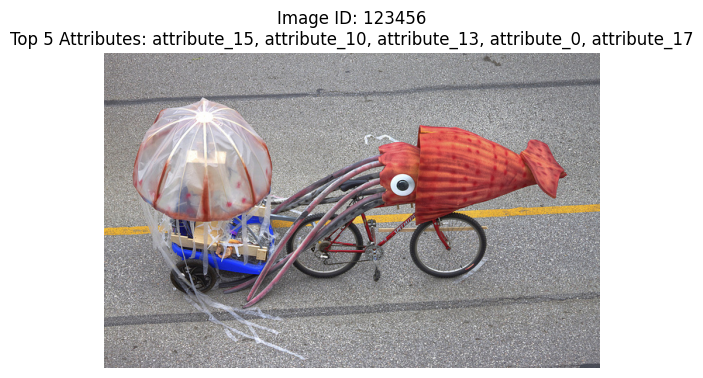

In [174]:
# Function to get top N attributes with a threshold of 0.5
def get_top_n_attributes(image_path, model, attr_to_idx, top_n=5, threshold=0.5):
    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad():
        output = model(image_tensor)

    # Apply sigmoid activation (since it's multi-label classification)
    probs = torch.sigmoid(output).squeeze().cpu().numpy()

    # Apply threshold: only consider attributes with probabilities above the threshold
    filtered_probs = [(i, prob) for i, prob in enumerate(probs) if prob >= threshold]

    # Sort by probability and get the top N attributes
    top_indices = [i for i, _ in sorted(filtered_probs, key=lambda x: x[1], reverse=True)[:top_n]]
    top_attributes = [list(attr_to_idx.keys())[i] for i in top_indices]

    return top_attributes, image

# Inspect a random image-label pair and get top attributes
random_image_id = random.choice(list(image_labels.keys()))
print(f"Image ID: {random_image_id}")
print(f"Attributes for the image (from dataset): {image_labels[random_image_id]}")

# Define image path and get top 5 predicted attributes with threshold
image_path = f"/content/COCO_VQA_2_unzipped/train2014/COCO_train2014_{random_image_id:012d}.jpg"
top_attributes, image = get_top_n_attributes(image_path, model, attr_to_idx, top_n=5, threshold=0.5)

# Print the top 5 attributes
print(f"Top 5 Predicted Attributes: {', '.join(top_attributes)}")

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.title(f"Image ID: {random_image_id}\nTop 5 Attributes: {', '.join(top_attributes)}")
plt.show()